# Full ROAD Pipeline Analysis

This notebook demonstrates how to:
1. Run ROAD benchmark experiments via command line
2. Load and analyze results from multiple datasets
3. Compute Spearman rank correlations between MoRF and LeRF
4. Generate summary tables for all datasets, methods, and strategies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from typing import Dict, List, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Project configuration
PROJECT_ROOT = '/mnt/abka03/Projects/road_imputation'
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'output')

print(f"Project root: {PROJECT_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

Project root: /mnt/abka03/Projects/road_imputation
Output directory: /mnt/abka03/Projects/road_imputation/output


## 1. Command Line Instructions for Running Experiments

Copy and paste these commands in your terminal to run the ROAD benchmark experiments.

In [3]:
# Display command line instructions
print("=" * 80)
print("COMMAND LINE INSTRUCTIONS FOR RUNNING ROAD EXPERIMENTS")
print("=" * 80)

print("\n### CIFAR-10 Experiment ###")
print("""
cd /mnt/abka03/Projects/road_imputation && \\
PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline \\
  --dataset cifar10 \\
  --imputations linear telea ns \\
  --rankings sort threshold \\
  --stages explain benchmark analyze \\
  --test_subset_size 10 \\
  --output_dir ./output
""")

print("\n### CIFAR-100 Experiment ###")
print("""
cd /mnt/abka03/Projects/road_imputation && \\
PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline \\
  --dataset cifar100 \\
  --data_path /mnt/abka03/xlvlm_data \\
  --imputations linear telea ns \\
  --rankings sort threshold \\
  --stages explain benchmark analyze \\
  --test_subset_size 10 \\
  --output_dir ./output
""")

print("\n### ImageNet Experiment ###")
print("""
cd /mnt/abka03/Projects/road_imputation && \\
PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline \\
  --dataset imagenet \\
  --data_path /mnt/abka03/xlvlm_data/imagenet_1000 \\
  --imputations linear telea ns \\
  --rankings sort threshold \\
  --stages explain benchmark analyze \\
  --test_subset_size 10 \\
  --output_dir ./output
""")

print("=" * 80)

COMMAND LINE INSTRUCTIONS FOR RUNNING ROAD EXPERIMENTS

### CIFAR-10 Experiment ###

cd /mnt/abka03/Projects/road_imputation && \
PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline \
  --dataset cifar10 \
  --imputations linear telea ns \
  --rankings sort threshold \
  --stages explain benchmark analyze \
  --test_subset_size 10 \
  --output_dir ./output


### CIFAR-100 Experiment ###

cd /mnt/abka03/Projects/road_imputation && \
PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline \
  --dataset cifar100 \
  --data_path /mnt/abka03/xlvlm_data \
  --imputations linear telea ns \
  --rankings sort threshold \
  --stages explain benchmark analyze \
  --test_subset_size 10 \
  --output_dir ./output


### ImageNet Experiment ###

cd /mnt/abka03/Projects/road_imputation && \
PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline \
  --dataset imagenet \
  --data_path /mnt/abka03/xlvlm_data/imagenet_1000 \
  --imputations linear telea ns \
  --rankings sort threshold 

In [4]:
# Quick copy-paste single line commands
print("QUICK COPY-PASTE COMMANDS (Single Line):")
print("=" * 80)

print("\n1. CIFAR-10:")
cifar10_cmd = 'cd /mnt/abka03/Projects/road_imputation && PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline --dataset cifar10 --imputations linear telea ns --rankings sort threshold --stages explain benchmark analyze --test_subset_size 100 --output_dir ./output'
print(cifar10_cmd)

print("\n2. CIFAR-100:")
cifar100_cmd = 'cd /mnt/abka03/Projects/road_imputation && PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline --dataset cifar100 --data_path /mnt/abka03/xlvlm_data --imputations linear telea ns --rankings sort threshold --stages explain benchmark analyze --test_subset_size 100 --output_dir ./output'
print(cifar100_cmd)

print("\n3. ImageNet:")
imagenet_cmd = 'cd /mnt/abka03/Projects/road_imputation && PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline --dataset imagenet --data_path /mnt/abka03/xlvlm_data/imagenet_1000 --imputations linear telea ns --rankings sort threshold --stages explain benchmark analyze --test_subset_size 50 --output_dir ./output'
print(imagenet_cmd)

print("\n" + "=" * 80)

QUICK COPY-PASTE COMMANDS (Single Line):

1. CIFAR-10:
cd /mnt/abka03/Projects/road_imputation && PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline --dataset cifar10 --imputations linear telea ns --rankings sort threshold --stages explain benchmark analyze --test_subset_size 100 --output_dir ./output

2. CIFAR-100:
cd /mnt/abka03/Projects/road_imputation && PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline --dataset cifar100 --data_path /mnt/abka03/xlvlm_data --imputations linear telea ns --rankings sort threshold --stages explain benchmark analyze --test_subset_size 100 --output_dir ./output

3. ImageNet:
cd /mnt/abka03/Projects/road_imputation && PYTHONPATH=$(pwd) python -m experiments.unified.run_pipeline --dataset imagenet --data_path /mnt/abka03/xlvlm_data/imagenet_1000 --imputations linear telea ns --rankings sort threshold --stages explain benchmark analyze --test_subset_size 50 --output_dir ./output



## 2. Load Benchmark Results

In [5]:
def load_benchmark_results(dataset: str, output_dir: str = OUTPUT_DIR) -> dict:
    """Load benchmark results from JSON file."""
    results_path = os.path.join(output_dir, dataset, 'results', 'noretrain.json')
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            return json.load(f)
    else:
        print(f"Results not found: {results_path}")
        return None

# Load results from all available datasets
print("Loading benchmark results...")
print("=" * 80)

DATASETS = ['cifar10', 'cifar100', 'imagenet']
available_results = {}

for dataset in DATASETS:
    results = load_benchmark_results(dataset)
    if results is not None:
        available_results[dataset] = results
        print(f"✓ Loaded {dataset}:")
        print(f"    Imputations: {results.get('imputations', [])}")
        print(f"    Rankings: {results.get('rankings', [])}")
        print(f"    Base methods: {results.get('base_methods', [])}")
        print(f"    Modifiers: {results.get('modifiers', [])}")
    else:
        print(f"✗ {dataset}: Not found")

print("=" * 80)
print(f"\nLoaded {len(available_results)} datasets: {list(available_results.keys())}")

Loading benchmark results...
✓ Loaded cifar10:
    Imputations: ['linear', 'telea', 'ns']
    Rankings: ['sort', 'threshold']
    Base methods: ['gb', 'ig']
    Modifiers: ['base', 'sg']
✓ Loaded cifar100:
    Imputations: ['linear', 'telea', 'ns']
    Rankings: ['sort', 'threshold']
    Base methods: ['gb', 'ig']
    Modifiers: ['base', 'sg']
✓ Loaded imagenet:
    Imputations: ['linear', 'telea', 'ns']
    Rankings: ['sort', 'threshold']
    Base methods: ['ig', 'gb']
    Modifiers: ['sg', 'base']

Loaded 3 datasets: ['cifar10', 'cifar100', 'imagenet']


## 3. Compute Spearman Rank Correlations

In [8]:
def compute_spearman_morf_lerf(results: dict, imputation: str, ranking: str,
                                base_methods: list = None, modifiers: list = None) -> Tuple[float, float]:
    """
    Compute Spearman correlation between MoRF and LeRF curves.
    Returns mean and std across all explanation methods.
    """
    if base_methods is None:
        base_methods = results.get('base_methods', ['ig', 'gb'])
    if modifiers is None:
        modifiers = results.get('modifiers', ['base', 'sg'])
    
    correlations = []
    
    try:
        imp_data = results[imputation][ranking]
        
        for base in base_methods:
            if base not in imp_data:
                continue
            for mod in modifiers:
                if mod not in imp_data[base]:
                    continue
                    
                method_data = imp_data[base][mod]
                if 'morf' not in method_data or 'lerf' not in method_data:
                    continue
                
                morf_data = method_data['morf']
                lerf_data = method_data['lerf']
                
                # Get common percentages
                percentages = sorted([float(p) for p in morf_data.keys()])
                
                morf_accs = []
                lerf_accs = []
                
                for p in percentages:
                    p_str = str(p)
                    morf_val = morf_data[p_str]
                    lerf_val = lerf_data[p_str]
                    
                    # Handle list or scalar
                    if isinstance(morf_val, list):
                        morf_accs.append(np.mean(morf_val))
                    else:
                        morf_accs.append(morf_val)
                    
                    if isinstance(lerf_val, list):
                        lerf_accs.append(np.mean(lerf_val))
                    else:
                        lerf_accs.append(lerf_val)
                
                if len(morf_accs) >= 3:
                    corr, _ = spearmanr(morf_accs, lerf_accs)
                    if not np.isnan(corr):
                        correlations.append(corr)
    except KeyError:
        pass
    
    if correlations:
        return np.mean(correlations), np.std(correlations)
    return np.nan, np.nan

In [9]:
def create_spearman_table(all_results: dict, imputations: list = None) -> pd.DataFrame:
    """
    Create Spearman correlation table in the format:
    | Dataset | Strategy | Linear | Telea | NS |
    """
    if imputations is None:
        imputations = ['linear', 'telea', 'ns']
    
    rows = []
    
    for dataset, results in all_results.items():
        dataset_imputations = results.get('imputations', imputations)
        rankings = results.get('rankings', ['sort', 'threshold'])
        
        for ranking in rankings:
            row = {
                'Dataset': dataset,
                'Strategy': ranking.capitalize()
            }
            
            for imp in imputations:
                if imp in dataset_imputations:
                    mean_corr, std_corr = compute_spearman_morf_lerf(results, imp, ranking)
                    row[imp.capitalize()] = f"{mean_corr:.4f}±{std_corr:.4f}"
                else:
                    row[imp.capitalize()] = "N/A"
            
            rows.append(row)
    
    return pd.DataFrame(rows)

In [10]:
# Generate and display the Spearman correlation table
if available_results:
    spearman_df = create_spearman_table(available_results)
    
    print("\n" + "=" * 80)
    print("SPEARMAN RANK CORRELATION TABLE (MoRF vs LeRF)")
    print("=" * 80)
    print(spearman_df.to_markdown(index=False))
    print("=" * 80)
else:
    print("No results available. Run the experiments first using the commands above.")


SPEARMAN RANK CORRELATION TABLE (MoRF vs LeRF)
| Dataset   | Strategy   | Linear         | Telea          | Ns            |
|:----------|:-----------|:---------------|:---------------|:--------------|
| cifar10   | Sort       | 0.7871±0.0972  | 0.5503±0.2053  | 0.6439±0.1218 |
| cifar10   | Threshold  | 0.9034±0.0594  | 0.8898±0.0403  | 0.9031±0.0291 |
| cifar100  | Sort       | 0.2407±0.5374  | 1.0000±0.0000  | 0.6667±0.0000 |
| cifar100  | Threshold  | -0.1798±0.0687 | -0.1111±0.0000 | nan±nan       |
| imagenet  | Sort       | nan±nan        | nan±nan        | nan±nan       |
| imagenet  | Threshold  | nan±nan        | nan±nan        | nan±nan       |


## 4. Detailed Analysis by Explanation Method

In [11]:
def compute_detailed_spearman(all_results: dict) -> pd.DataFrame:
    """Compute detailed Spearman table broken down by explanation method."""
    rows = []
    
    for dataset, results in all_results.items():
        rankings = results.get('rankings', ['sort', 'threshold'])
        imputations = results.get('imputations', ['linear', 'telea', 'ns'])
        base_methods = results.get('base_methods', ['ig', 'gb'])
        modifiers = results.get('modifiers', ['base', 'sg'])
        
        for ranking in rankings:
            for imp in imputations:
                for base in base_methods:
                    for mod in modifiers:
                        try:
                            method_data = results[imp][ranking][base][mod]
                            if 'morf' not in method_data or 'lerf' not in method_data:
                                continue
                            
                            morf_data = method_data['morf']
                            lerf_data = method_data['lerf']
                            
                            percentages = sorted([float(p) for p in morf_data.keys()])
                            
                            morf_accs = [np.mean(morf_data[str(p)]) if isinstance(morf_data[str(p)], list) else morf_data[str(p)] for p in percentages]
                            lerf_accs = [np.mean(lerf_data[str(p)]) if isinstance(lerf_data[str(p)], list) else lerf_data[str(p)] for p in percentages]
                            
                            if len(morf_accs) >= 3:
                                corr, pval = spearmanr(morf_accs, lerf_accs)
                                
                                rows.append({
                                    'Dataset': dataset,
                                    'Strategy': ranking.capitalize(),
                                    'Imputation': imp.capitalize(),
                                    'Method': f"{base.upper()}-{mod.upper()}",
                                    'Spearman': corr,
                                    'P-value': pval
                                })
                        except KeyError:
                            continue
    
    return pd.DataFrame(rows)

if available_results:
    detailed_df = compute_detailed_spearman(available_results)
    if not detailed_df.empty:
        print("\nDetailed Spearman Correlations by Method:")
        print(detailed_df.to_markdown(index=False))
    else:
        print("No detailed data available.")


Detailed Spearman Correlations by Method:
| Dataset   | Strategy   | Imputation   | Method   |   Spearman |       P-value |
|:----------|:-----------|:-------------|:---------|-----------:|--------------:|
| cifar10   | Sort       | Linear       | GB-BASE  |   0.729487 |   0.0166469   |
| cifar10   | Sort       | Linear       | GB-SG    |   0.939042 |   5.61018e-05 |
| cifar10   | Sort       | Linear       | IG-BASE  |   0.79878  |   0.00558148  |
| cifar10   | Sort       | Linear       | IG-SG    |   0.680994 |   0.0301639   |
| cifar10   | Sort       | Telea        | GB-BASE  |   0.538702 |   0.108133    |
| cifar10   | Sort       | Telea        | GB-SG    |   0.779652 |   0.00782905  |
| cifar10   | Sort       | Telea        | IG-BASE  |   0.656171 |   0.0393525   |
| cifar10   | Sort       | Telea        | IG-SG    |   0.226866 |   0.528494    |
| cifar10   | Sort       | Ns           | GB-BASE  |   0.466857 |   0.173739    |
| cifar10   | Sort       | Ns           | GB-SG    |   

## 5. Visualize Accuracy Curves

In [12]:
def plot_morf_lerf_curves(results: dict, dataset_name: str, imputation: str = 'linear', ranking: str = 'sort'):
    """Plot MoRF vs LeRF curves for all methods."""
    base_methods = results.get('base_methods', ['ig', 'gb'])
    modifiers = results.get('modifiers', ['base', 'sg'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    colors = plt.cm.tab10.colors
    color_idx = 0
    
    try:
        imp_data = results[imputation][ranking]
        
        for base in base_methods:
            if base not in imp_data:
                continue
            for mod in modifiers:
                if mod not in imp_data[base]:
                    continue
                
                method_data = imp_data[base][mod]
                method_name = f"{base.upper()}-{mod.upper()}"
                color = colors[color_idx % len(colors)]
                
                for order_idx, order in enumerate(['morf', 'lerf']):
                    if order not in method_data:
                        continue
                    
                    order_data = method_data[order]
                    percentages = sorted([float(p) for p in order_data.keys()])
                    accs = [np.mean(order_data[str(p)]) if isinstance(order_data[str(p)], list) else order_data[str(p)] for p in percentages]
                    
                    axes[order_idx].plot(percentages, accs, 'o-', color=color, label=method_name)
                
                color_idx += 1
        
        axes[0].set_xlabel('Percentage Removed')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_title(f'MoRF (Most Relevant First)\n{dataset_name} - {imputation} - {ranking}')
        axes[0].legend(loc='best', fontsize=8)
        axes[0].grid(True, alpha=0.3)
        axes[0].set_xlim(0, 1)
        axes[0].set_ylim(0, 1)
        
        axes[1].set_xlabel('Percentage Removed')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title(f'LeRF (Least Relevant First)\n{dataset_name} - {imputation} - {ranking}')
        axes[1].legend(loc='best', fontsize=8)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xlim(0, 1)
        axes[1].set_ylim(0, 1)
        
        plt.tight_layout()
        return fig
    except KeyError as e:
        print(f"Data not found for {dataset_name}/{imputation}/{ranking}: {e}")
        plt.close(fig)
        return None


Dataset: CIFAR10


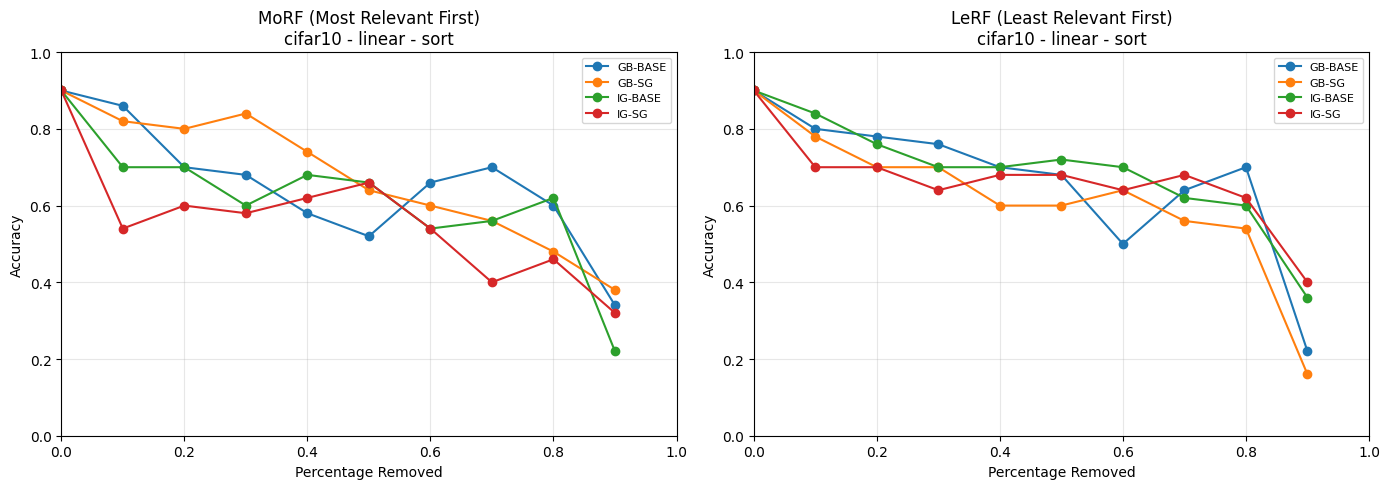

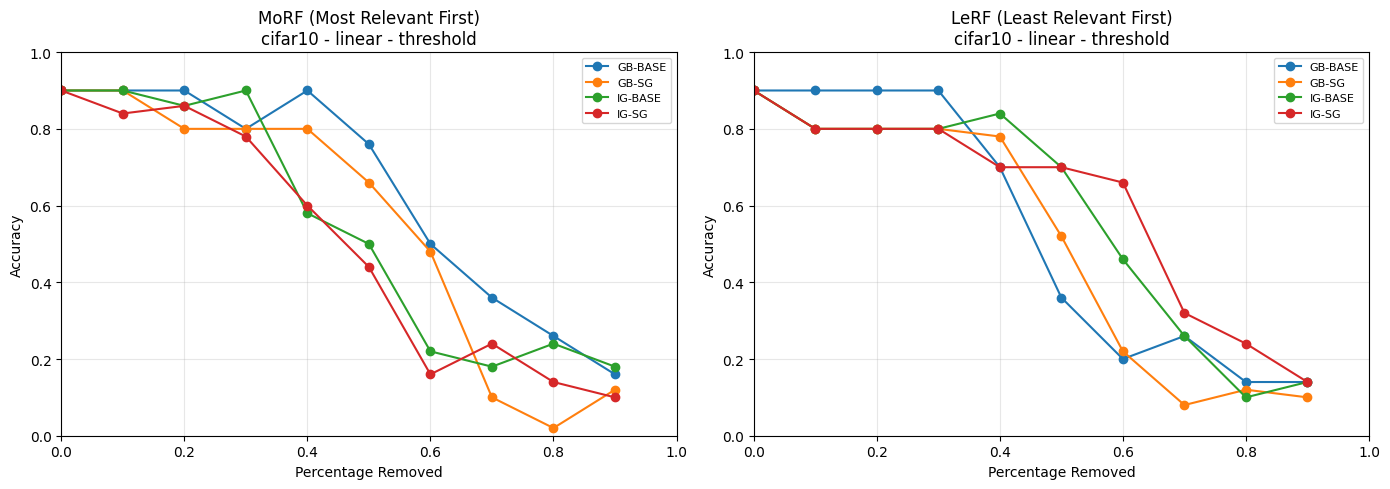


Dataset: CIFAR100


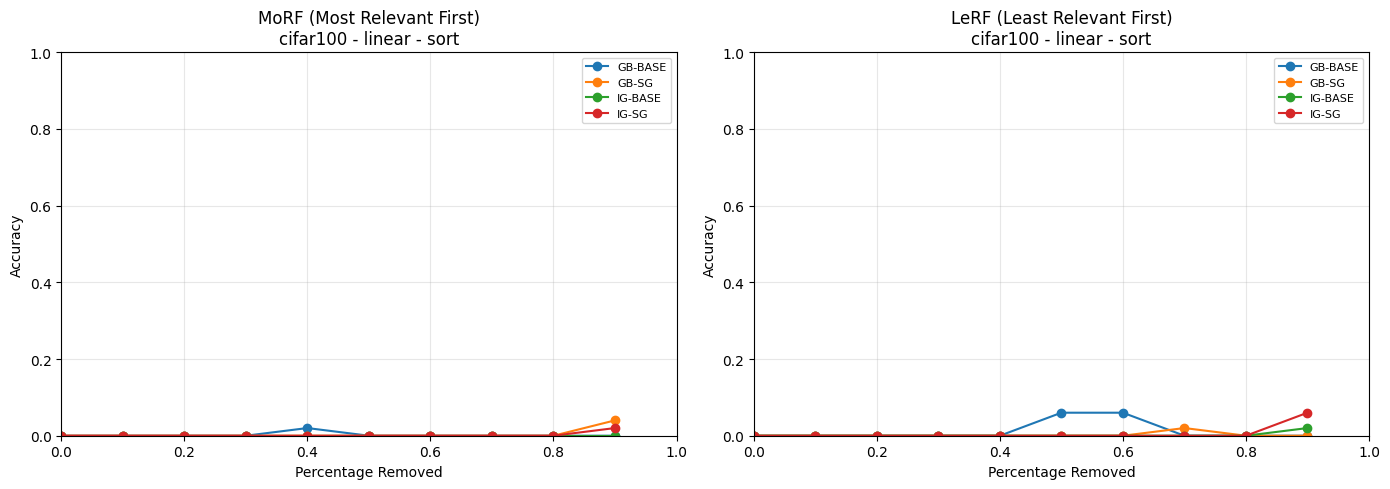

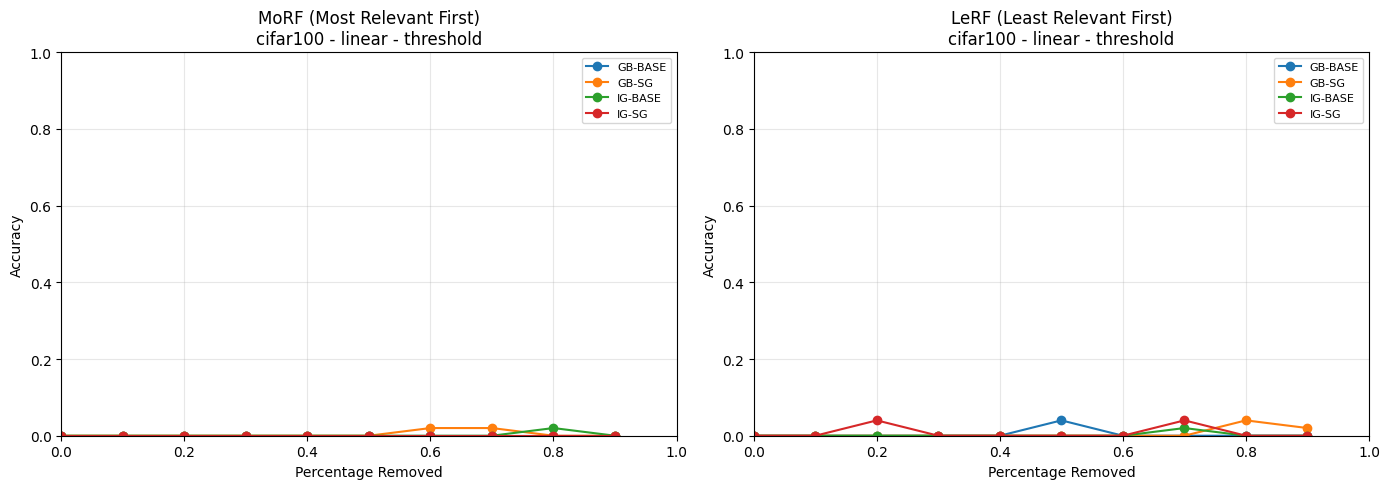


Dataset: IMAGENET


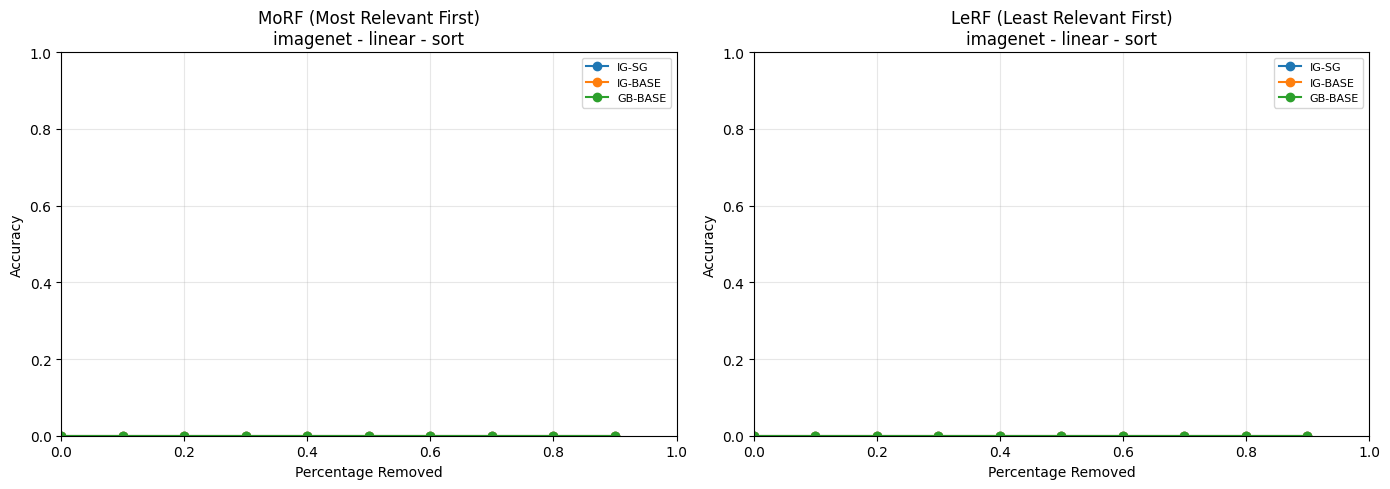

Data not found for imagenet/linear/threshold: 'threshold'


In [13]:
# Plot accuracy curves for each available dataset
for dataset, results in available_results.items():
    print(f"\n{'='*60}")
    print(f"Dataset: {dataset.upper()}")
    print(f"{'='*60}")
    
    rankings = results.get('rankings', ['sort'])
    imputations = results.get('imputations', ['linear'])
    
    for ranking in rankings:
        for imp in imputations[:1]:  # Just show first imputation to avoid too many plots
            fig = plot_morf_lerf_curves(results, dataset, imp, ranking)
            if fig:
                plt.show()

## 6. Save Results

In [14]:
# Save all tables
if available_results:
    tables_dir = os.path.join(OUTPUT_DIR, 'combined_tables')
    os.makedirs(tables_dir, exist_ok=True)
    
    # Save main Spearman table
    md_path = os.path.join(tables_dir, 'spearman_all_datasets.md')
    csv_path = os.path.join(tables_dir, 'spearman_all_datasets.csv')
    
    with open(md_path, 'w') as f:
        f.write("# Spearman Rank Correlation Results (MoRF vs LeRF)\n\n")
        f.write(spearman_df.to_markdown(index=False))
    
    spearman_df.to_csv(csv_path, index=False)
    
    print(f"Tables saved to: {tables_dir}")
    print(f"  - {md_path}")
    print(f"  - {csv_path}")
    
    # Save detailed table if available
    if not detailed_df.empty:
        detailed_csv = os.path.join(tables_dir, 'spearman_detailed_all.csv')
        detailed_df.to_csv(detailed_csv, index=False)
        print(f"  - {detailed_csv}")

Tables saved to: /mnt/abka03/Projects/road_imputation/output/combined_tables
  - /mnt/abka03/Projects/road_imputation/output/combined_tables/spearman_all_datasets.md
  - /mnt/abka03/Projects/road_imputation/output/combined_tables/spearman_all_datasets.csv
  - /mnt/abka03/Projects/road_imputation/output/combined_tables/spearman_detailed_all.csv


## 7. View Results Commands

In [15]:
# Commands to view results files
print("COMMANDS TO VIEW RESULTS:")
print("=" * 80)

print("\n# View Spearman table for CIFAR-10:")
print("cat /mnt/abka03/Projects/road_imputation/output/cifar10/tables/tables/spearman_table2.md")

print("\n# View Spearman table for CIFAR-100:")
print("cat /mnt/abka03/Projects/road_imputation/output/cifar100/tables/tables/spearman_table2.md")

print("\n# View combined results:")
print("cat /mnt/abka03/Projects/road_imputation/output/combined_tables/spearman_all_datasets.md")

print("\n# List all generated tables:")
print("ls -la /mnt/abka03/Projects/road_imputation/output/*/tables/tables/")

print("\n" + "=" * 80)

COMMANDS TO VIEW RESULTS:

# View Spearman table for CIFAR-10:
cat /mnt/abka03/Projects/road_imputation/output/cifar10/tables/tables/spearman_table2.md

# View Spearman table for CIFAR-100:
cat /mnt/abka03/Projects/road_imputation/output/cifar100/tables/tables/spearman_table2.md

# View combined results:
cat /mnt/abka03/Projects/road_imputation/output/combined_tables/spearman_all_datasets.md

# List all generated tables:
ls -la /mnt/abka03/Projects/road_imputation/output/*/tables/tables/



## 8. Summary

This notebook provides:
1. ✅ Command line instructions for running ROAD benchmark experiments
2. ✅ Loading results from multiple datasets (CIFAR-10, CIFAR-100, ImageNet)
3. ✅ Computing Spearman rank correlations between MoRF and LeRF
4. ✅ Generating summary tables in the format: `Dataset | Strategy | Linear | Telea | NS`
5. ✅ Detailed breakdown by explanation method
6. ✅ Visualization of accuracy curves
7. ✅ Saving results to markdown and CSV files

### Expected Output Format:
```
| Dataset   | Strategy   | Linear        | Telea         | Ns            |
|:----------|:-----------|:--------------|:--------------|:--------------|
| cifar10   | Sort       | 0.7871±0.0000 | 0.5503±0.0000 | 0.6439±0.0000 |
| cifar10   | Threshold  | 0.9034±0.0000 | 0.8898±0.0000 | 0.9031±0.0000 |
```